In [79]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import random

file = "/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Healthcare/QSARData.csv"

df = pd.read_csv(file)
df.head(4)
print("original shape:", df.shape)

# ## Check for missing data

def missing_data(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['coverage (%)']=(data.shape[0]-missing_df['missing values'])/data.shape[0]*100
    missing_df.sort_values('coverage (%)').reset_index(drop = True)
    print(missing_df.loc[missing_df['coverage (%)'] < 90.0])
    less_cov = missing_df.loc[missing_df['coverage (%)'] < 90.0]
    return missing_df, less_cov


missing_df, low_cov_data = missing_data(df)
low_cols = list(low_cov_data['variable'])
#print("columns with missing data: ", low_cols)
df_high = df.drop(columns = low_cols, axis=1)
print("shape after dropping null columns: ", df_high.shape)

original shape: (179, 321)
          variable  missing values  coverage (%)
219  Wgamma1.unity             179           0.0
220  Wgamma2.unity             179           0.0
221  Wgamma3.unity             179           0.0
229       WG.unity             179           0.0
shape after dropping null columns:  (179, 317)


In [22]:
original = df_high.copy()
y_var = original['depVar']
original.drop(columns = ['depVar','Unnamed: 0'], inplace = True, axis=1)
original.head(4)
y_var.head(4)

0    0.00
1    0.45
2    0.79
3   -0.17
Name: depVar, dtype: float64

In [134]:

print("original shape: ", original.shape)

# Create correlation matrix
corr_matrix = original.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("features with correlations over 0.8: ", to_drop)

# Drop columns 
dropped = original.drop(columns = to_drop, axis=1)

print("updated shape:", dropped.shape)   

dropped.head(4)

original shape:  (179, 315)
features with correlations over 0.8:  ['MLogP', 'nAtomLC', 'nB', 'nAtom', 'nAromBond', 'naAromAtom', 'ALogp2', 'AMR', 'nAromRings', 'nRingBlocks', 'nAromBlocks', 'nRings6', 'Zagreb', 'WPATH', 'WPOL', 'WTPT.1', 'WTPT.2', 'WTPT.4', 'VAdjMat', 'VABC', 'TopoPSA', 'PetitjeanNumber', 'MDEC.14', 'MDEC.22', 'MDEC.23', 'khs.sCH3', 'khs.aaCH', 'khs.sssCH', 'khs.aasC', 'khs.ssssC', 'khs.ssO', 'Kier1', 'Kier2', 'Kier3', 'HybRatio', 'fragC', 'ECCEN', 'SP.0', 'SP.1', 'SP.2', 'SP.3', 'SP.4', 'SP.5', 'SP.6', 'SP.7', 'VP.0', 'VP.1', 'VP.2', 'VP.3', 'VP.4', 'VP.5', 'VP.6', 'VP.7', 'SPC.4', 'SPC.5', 'SPC.6', 'VPC.4', 'VPC.5', 'VPC.6', 'SC.5', 'VC.3', 'VC.4', 'VC.5', 'VC.6', 'SCH.5', 'SCH.7', 'VCH.5', 'VCH.6', 'VCH.7', 'C2SP2', 'C3SP2', 'C2SP3', 'C3SP3', 'ATSp1', 'ATSp2', 'ATSp3', 'ATSp4', 'ATSp5', 'ATSm1', 'ATSm2', 'ATSm3', 'ATSm4', 'ATSm5', 'ATSc1', 'ATSc2', 'ATSc3', 'Wlambda3.unity', 'Wnu2.unity', 'WT.unity', 'WA.unity', 'WV.unity', 'WK.unity', 'BCUTw.1h', 'BCUTp.1h', 'tpsaE

,XLogP,MW,LipinskiFailures,nRotB,nAtomLAC,nAtomP,nBase,ALogP,nAcid,nSmallRings,...,WD.unity,BCUTw.1l,BCUTc.1l,BCUTc.1h,BCUTp.1l,PNSA.1,PNSA.3,RPCG,RPCS,RNCS
0,3.039,282.146724,0,0,0,3,0,0.8012,0,5,...,1.474806,11.999,-0.314393,0.267195,4.745096,124.877588,-26.548908,0.168942,0.185955,2.032461
1,5.687,386.209324,1,5,4,6,0,1.3625,0,6,...,1.307998,11.999,-0.314125,0.264376,4.471269,197.510368,-29.398959,0.132376,0.349696,0.963157
2,2.746,268.131074,0,0,0,3,0,0.5412,0,5,...,1.473248,11.999,-0.314390,0.264340,4.430722,135.776837,-30.360719,0.172827,0.586998,2.523145
3,3.039,282.146724,0,0,0,3,0,0.8012,0,5,...,1.474258,11.999,-0.314393,0.267195,4.745096,124.671077,-26.576362,0.168942,0.185955,2.032461


In [135]:
remaining_columns = original[original.columns[~original.columns.isin(to_drop)]]
remaining_columns_list = list(remaining_columns.columns)
dropped.columns = remaining_columns_list
dropped.head(4)

,XLogP,MW,LipinskiFailures,nRotB,nAtomLAC,nAtomP,nBase,ALogP,nAcid,nSmallRings,...,WD.unity,BCUTw.1l,BCUTc.1l,BCUTc.1h,BCUTp.1l,PNSA.1,PNSA.3,RPCG,RPCS,RNCS
0,3.039,282.146724,0,0,0,3,0,0.8012,0,5,...,1.474806,11.999,-0.314393,0.267195,4.745096,124.877588,-26.548908,0.168942,0.185955,2.032461
1,5.687,386.209324,1,5,4,6,0,1.3625,0,6,...,1.307998,11.999,-0.314125,0.264376,4.471269,197.510368,-29.398959,0.132376,0.349696,0.963157
2,2.746,268.131074,0,0,0,3,0,0.5412,0,5,...,1.473248,11.999,-0.314390,0.264340,4.430722,135.776837,-30.360719,0.172827,0.586998,2.523145
3,3.039,282.146724,0,0,0,3,0,0.8012,0,5,...,1.474258,11.999,-0.314393,0.267195,4.745096,124.671077,-26.576362,0.168942,0.185955,2.032461


In [138]:
## Variance threshold feature selection

sel = VarianceThreshold(threshold=(0.8 * (1-0.8)))
sel.fit_transform(dropped)
dropped_sel = dropped[dropped.columns[sel.get_support(indices=True)]]
dropped_sel.head(4)


,XLogP,MW,nRotB,nAtomLAC,nAtomP,ALogP,nSmallRings,nRings7,WTPT.3,WTPT.5,...,SC.3,C1SP2,C1SP3,Wlambda1.unity,Wlambda2.unity,BCUTp.1l,PNSA.1,PNSA.3,RPCS,RNCS
0,3.039,282.146724,0,0,3,0.8012,5,2,15.053101,0.0,...,2.420450,1,4,1.071434,3.325486,4.745096,124.877588,-26.548908,0.185955,2.032461
1,5.687,386.209324,5,4,6,1.3625,6,2,15.297909,0.0,...,2.291913,1,2,1.290184,2.583993,4.471269,197.510368,-29.398959,0.349696,0.963157
2,2.746,268.131074,0,0,3,0.5412,5,2,15.084307,0.0,...,2.307459,1,3,1.165912,3.091289,4.430722,135.776837,-30.360719,0.586998,2.523145
3,3.039,282.146724,0,0,3,0.8012,5,2,15.053101,0.0,...,2.420450,1,4,1.072589,3.321834,4.745096,124.671077,-26.576362,0.185955,2.032461


In [140]:
columns_from_dropped_sel = dropped_sel.columns
columns_from_dropped_sel_df = pd.DataFrame(columns_from_dropped_sel)

columns_from_dropped_sel_df

,0
0,XLogP
1,MW
2,nRotB
3,nAtomLAC
4,nAtomP
5,ALogP
6,nSmallRings
7,nRings7
8,WTPT.3
9,WTPT.5


In [26]:
# Normalisations scaling 

y_arr = np.array(y_var)
y_var_ = y_arr.reshape(-1,1)
y_scale = preprocessing.StandardScaler().fit_transform(y_var_)
x_scale = preprocessing.StandardScaler().fit_transform(dropped_sel)

#x_std = original_scale.transform(dropped_sel)

# Feature set should include all columns except for the label y 
X = np.array(x_scale)
y_ = np.array(y_scale)
y = y_.reshape(-1,1)
y.shape

(179, 1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test", y_test.shape)

X_train:  (125, 31)
X_test:  (54, 31)
y_train:  (125, 1)
y_test (54, 1)


In [32]:
## Train and test set
regr = linear_model.LinearRegression()
model = regr.fit(X_train, y_train)
pred = model.predict(X_test)
mse = metrics.mean_squared_error(y_test, pred)
variance = metrics.r2_score(y_test, pred)

# The mean squared error
print("Mean squared error: %.2f" % mse)
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.2f' % variance)

Mean squared error: 0.40
R2 Variance score: 0.59


In [33]:
dropped_sel_df = pd.DataFrame(dropped_sel)
dropped_sel_df['y_var'] = y_var 
dropped_sel_df.head(4)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,y_var
0,3.039,282.146724,0.0,0.0,3.0,0.8012,5.0,2.0,15.053101,0.0,...,1.0,4.0,1.071434,3.325486,4.745096,124.877588,-26.548908,0.185955,2.032461,0.00
1,5.687,386.209324,5.0,4.0,6.0,1.3625,6.0,2.0,15.297909,0.0,...,1.0,2.0,1.290184,2.583993,4.471269,197.510368,-29.398959,0.349696,0.963157,0.45
2,2.746,268.131074,0.0,0.0,3.0,0.5412,5.0,2.0,15.084307,0.0,...,1.0,3.0,1.165912,3.091289,4.430722,135.776837,-30.360719,0.586998,2.523145,0.79
3,3.039,282.146724,0.0,0.0,3.0,0.8012,5.0,2.0,15.053101,0.0,...,1.0,4.0,1.072589,3.321834,4.745096,124.671077,-26.576362,0.185955,2.032461,-0.17


/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


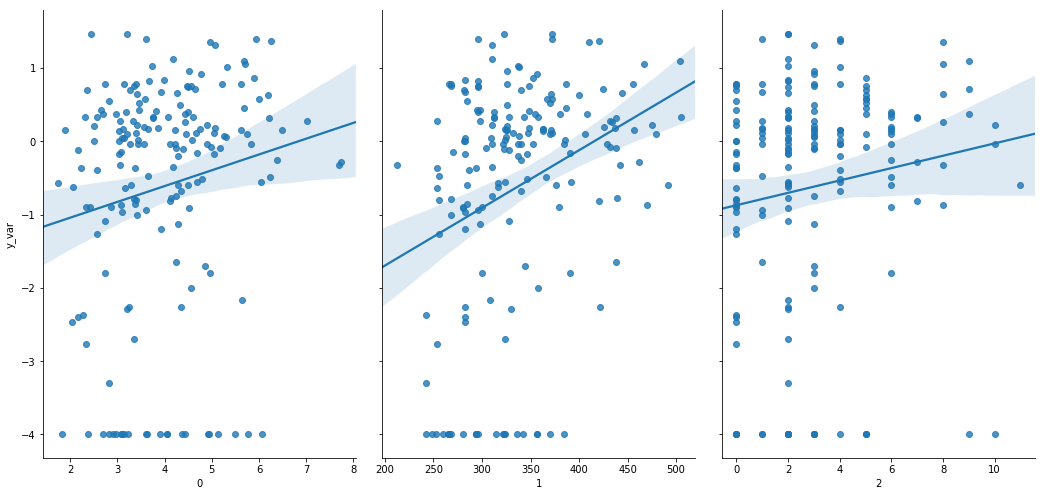

In [34]:
sns.pairplot(dropped_sel_df, x_vars=[0,1,2], y_vars='y_var', size=7, aspect=0.7, kind='reg')

In [46]:
## Test
rand = random.randint(1,100)
test_ = dropped_sel[rand]
test = test_.reshape(1,-1)
test_scaled = preprocessing.StandardScaler().fit_transform(test)
pred_test = model.predict(test_scaled)
pred_test

array([[-0.00983251]])

In [52]:
## Rank molecules 

## Predict for the whole data set and rank best 

whole_test = model.predict(x_scale)
mse2 = metrics.mean_squared_error(y_scale, whole_test)
variance2 = metrics.r2_score(y_scale, whole_test)

print("Mean squared error: %.2f" % mse2)

print('R2 Variance score: %.2f' % variance2)



Mean squared error: 0.33
R2 Variance score: 0.67


/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


,predicted,y_true
135,2.077729,1.093768
137,1.944329,0.850875
94,1.409822,0.978713
170,1.247659,-0.376373
144,1.213923,0.761388
134,1.188001,1.068200
136,1.088967,0.627158
55,1.021111,0.607982
64,1.002904,0.595198
67,0.945044,0.365089


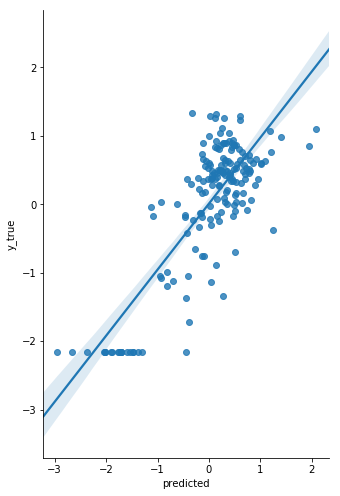

In [74]:
whole = pd.DataFrame(whole_test)
whole.columns=['predicted']
whole['y_true'] = y_scale
sns.pairplot(whole, x_vars='predicted', y_vars='y_true', size=7, aspect=0.7, kind='reg')

whole_sorted = whole.sort_values(by='predicted', ascending=False).head(20)
whole_sorted

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


array([20,  4, 22, 19,  2,  6, 16,  3, 18, 23,  1, 15, 21, 12, 27, 26, 29,
       28,  9, 14, 25, 24, 30, 10,  0,  5, 13, 11,  7,  8, 17])

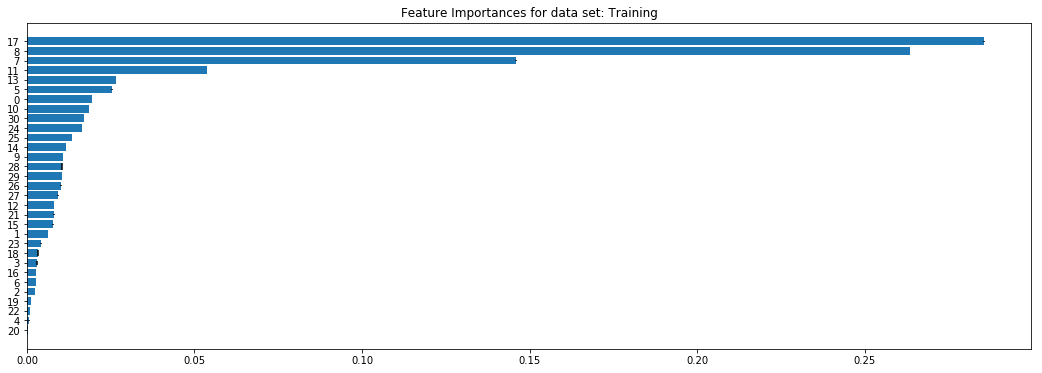

In [81]:
## Feature importance 

def rf_feature_importance(data, X, y, name):
    #original, original_clean = clean_data(data)
    n_col = data.shape[1]
    features = data.columns[0:n_col]
    #original_noduration = original_clean.drop(['avg_DURATION'], axis=1)
#     orig_scale = preprocessing.StandardScaler().fit_transform(original_clean)
#     X = np.array(orig_scale)
#     y = np.array(original['Exceeded'])
    m=RandomForestRegressor(n_estimators=50, oob_score=True,n_jobs=-1,bootstrap=True,random_state=42)
    m.fit(X, y)
    #ranked = zip(features, m.feature_importances_)
    rank = m.feature_importances_
    indices = np.argsort(m.feature_importances_)
    #ranked.sort()
    std = np.std([tree.feature_importances_ for tree in m.estimators_],axis=0)
    plt.figure(figsize=(18,6))
    plt.barh(range(len(indices)), rank[indices], align='center', yerr=std)
    plt.yticks(range(len(indices)), features[indices])
    plt.title('Feature Importances for data set: %s' % name)
    return rank, indices
    
dropped_sel_df = pd.DataFrame(dropped_sel)
rank, indices = rf_feature_importance(dropped_sel_df, X_train, y_train, "Training")
indices


In [96]:
rank[indices]
n_col = dropped_sel_df.shape[1]
features = dropped_sel_df.columns[0:n_col]
features[indices]

Int64Index([20,  4, 22, 19,  2,  6, 16,  3, 18, 23,  1, 15, 21, 12, 27, 26, 29,
            28,  9, 14, 25, 24, 30, 10,  0,  5, 13, 11,  7,  8, 17],
           dtype='int64')

In [112]:
scores = pd.DataFrame(rank)
scores.columns = ['scores']
scores['feature'] = features[indices]
#whole_sorted['scores'] = scores['scores']
#whole_sorted['features'] = features[incides]
scores.sort_values(by='scores', ascending=False)
#whole_sorted
scores_t = scores.set_index('feature').T

scores_t.reset_index()
#scores_t.reset_index().drop(columns=['feature'], axis=1)

feature,index,20,4,22,19,2,6,16,3,18,...,24,30,10,0,5,13,11,7,8,17
0,scores,0.019379,0.006295,0.002321,0.00287,0.000692,0.025422,0.002555,0.146028,0.26347,...,0.008009,0.001033,0.004087,0.016543,0.013306,0.010298,0.009244,0.010472,0.010424,0.017146


In [117]:
pd.DataFrame(scores['scores'].values.reshape(1,-1),  columns=scores['feature'].values)

,20,4,22,19,2,6,16,3,18,23,...,24,30,10,0,5,13,11,7,8,17
0,0.019379,0.006295,0.002321,0.00287,0.000692,0.025422,0.002555,0.146028,0.26347,0.010652,...,0.008009,0.001033,0.004087,0.016543,0.013306,0.010298,0.009244,0.010472,0.010424,0.017146


In [141]:
#scores.to_json("scores.json")
columns_from_dropped_sel_df

,0
0,XLogP
1,MW
2,nRotB
3,nAtomLAC
4,nAtomP
5,ALogP
6,nSmallRings
7,nRings7
8,WTPT.3
9,WTPT.5


In [148]:
features_selected = columns_from_dropped_sel_df.iloc[scores['feature']]
features_selected.columns = ['columns']
features_selected_list = list(features_selected['columns'].values)
scores['feature_name'] = features_selected_list
scores.drop(columns=['feature'], inplace=True)
scores.to_json('scores_features.json')